--BRFSS Annual Survey Data (for time-based and geographic analyses)--

In [ ]:
import pandas as pd
import os

# Files: LLCP2019.XPT to LLCP2023.XPT
years = ['2019', '2020', '2021', '2022', '2023']
columns = ['DIABETE4', 'SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']

dfs = []

for year in years:
    filename = f"LLCP{year}.XPT"
    df = pd.read_sas(filename, format='xport')
    df['year'] = int(year)

    # Select only available columns
    valid_cols = [col for col in columns if col in df.columns]
    df = df[valid_cols + ['year']]

    dfs.append(df)

# Combine all years
combined_df = pd.concat(dfs, ignore_index=True)
print("Combined shape:", combined_df.shape)


/tmp/ipython-input-5-1169689124.py:12: UserWarning: xport file may be corrupted.
  df = pd.read_sas(filename, format='xport')
/tmp/ipython-input-5-1169689124.py:12: UserWarning: xport file may be corrupted.
  df = pd.read_sas(filename, format='xport')
/tmp/ipython-input-5-1169689124.py:12: UserWarning: xport file may be corrupted.
  df = pd.read_sas(filename, format='xport')


Combined shape: (1675196, 6)


In [6]:
df = combined_df.copy()

# Replace invalid/missing codes with NaN
for col in ['DIABETE4', 'SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']:
    df[col] = df[col].replace([7, 9, 77, 88, 99, 777, 999], pd.NA)

# Create binary diabetes target
df['diabetes'] = df['DIABETE4'].replace({
    1: 1,   # Yes
    2: 0,   # No
    3: 0,   # Borderline
    4: 0    # During pregnancy
})

# Drop the original column
df = df.drop(columns=['DIABETE4'])

# Impute missing values (using mode for categorical/ordinal)
for col in ['SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Final cleaned dataset
clean_df = df.copy()

# Confirm readiness
print(" Cleaned dataset shape:", clean_df.shape)
print("\n Records per year:")
print(clean_df['year'].value_counts())


/tmp/ipython-input-6-3593212284.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


 Cleaned dataset shape: (1675196, 6)

 Records per year:
year
2020    384080
2021    348635
2022    325499
2019    311700
2023    305282
Name: count, dtype: int64



Processing Year: 2019
Using 4 features: ['SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']
Optimal Threshold (best F1): 0.7939

Classification Report for 2019
              precision    recall  f1-score   support

           0       0.89      0.59      0.71     53706
           1       0.17      0.52      0.25      8505

    accuracy                           0.58     62211
   macro avg       0.53      0.56      0.48     62211
weighted avg       0.79      0.58      0.65     62211

False Positives: 21983 (40.93%)
False Negatives: 4056 (47.69%)
Precision: 0.1683
Recall: 0.5231


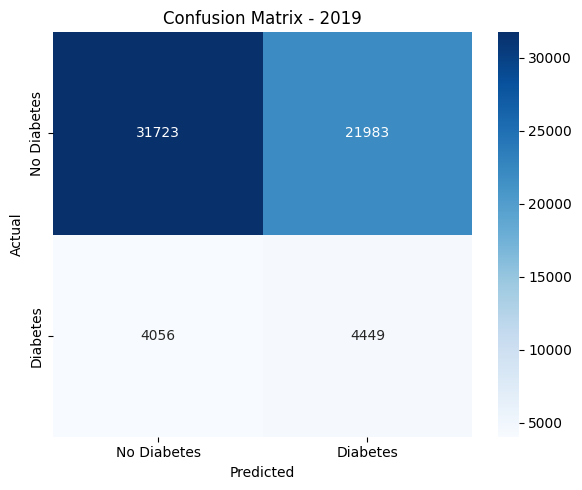

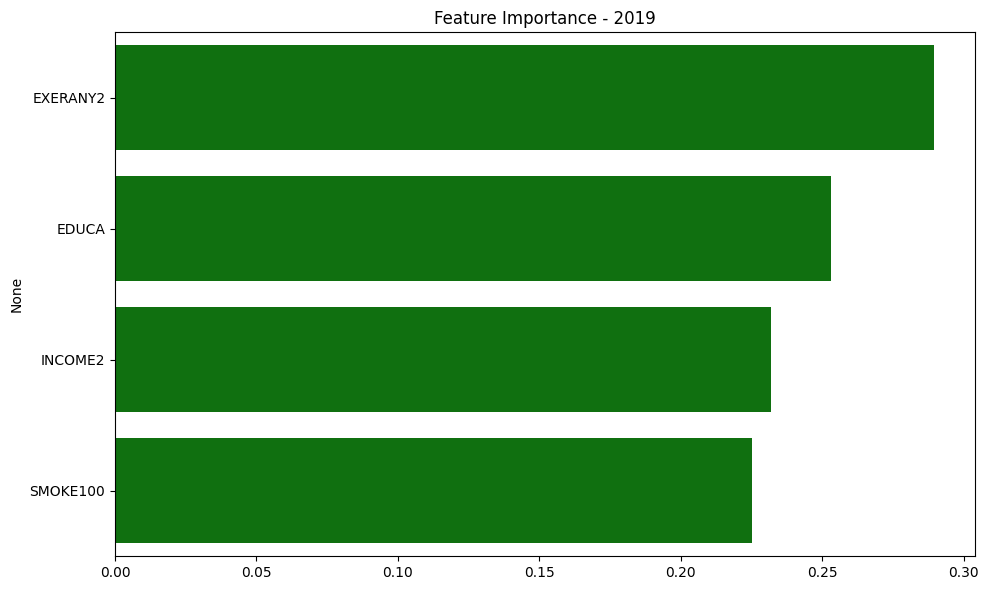


Processing Year: 2020
Using 4 features: ['SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']
Optimal Threshold (best F1): 0.7939

Classification Report for 2020
              precision    recall  f1-score   support

           0       0.90      0.60      0.72     66724
           1       0.17      0.53      0.25      9936

    accuracy                           0.59     76660
   macro avg       0.53      0.57      0.49     76660
weighted avg       0.80      0.59      0.66     76660

False Positives: 26648 (39.94%)
False Negatives: 4624 (46.54%)
Precision: 0.1662
Recall: 0.5346


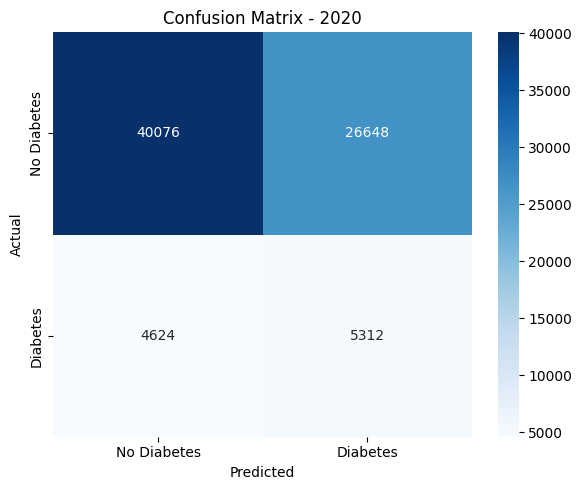

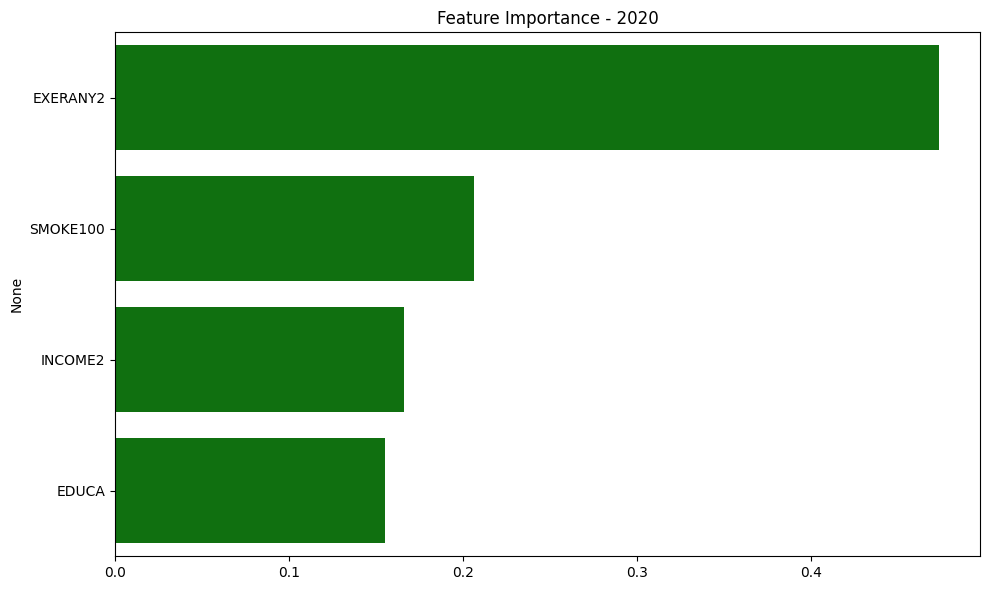


Processing Year: 2021
Using 4 features: ['SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']
Optimal Threshold (best F1): 0.8459

Classification Report for 2021
              precision    recall  f1-score   support

           0       0.90      0.76      0.82     60458
           1       0.21      0.42      0.28      9116

    accuracy                           0.71     69574
   macro avg       0.55      0.59      0.55     69574
weighted avg       0.81      0.71      0.75     69574

False Positives: 14774 (24.44%)
False Negatives: 5270 (57.81%)
Precision: 0.2066
Recall: 0.4219


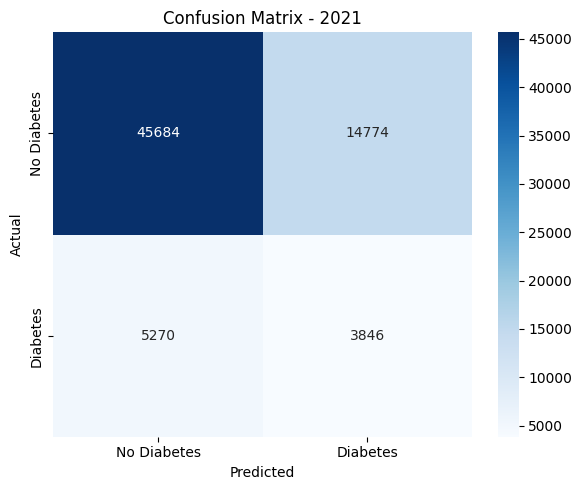

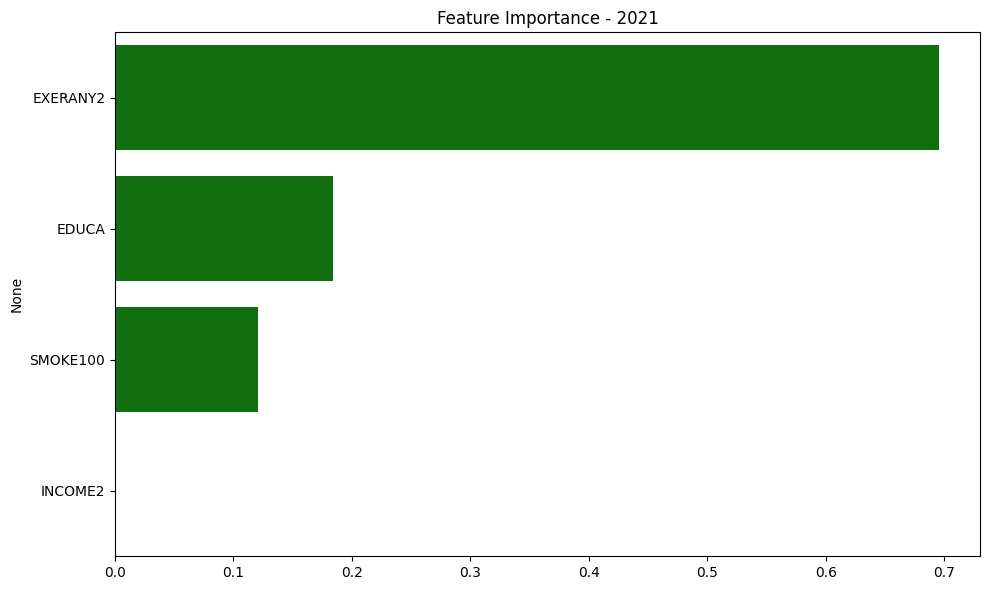


Processing Year: 2022
Using 4 features: ['SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']
Optimal Threshold (best F1): 0.8286

Classification Report for 2022
              precision    recall  f1-score   support

           0       0.90      0.68      0.78     56067
           1       0.20      0.51      0.29      8869

    accuracy                           0.66     64936
   macro avg       0.55      0.60      0.53     64936
weighted avg       0.80      0.66      0.71     64936

False Positives: 17703 (31.57%)
False Negatives: 4373 (49.31%)
Precision: 0.2025
Recall: 0.5069


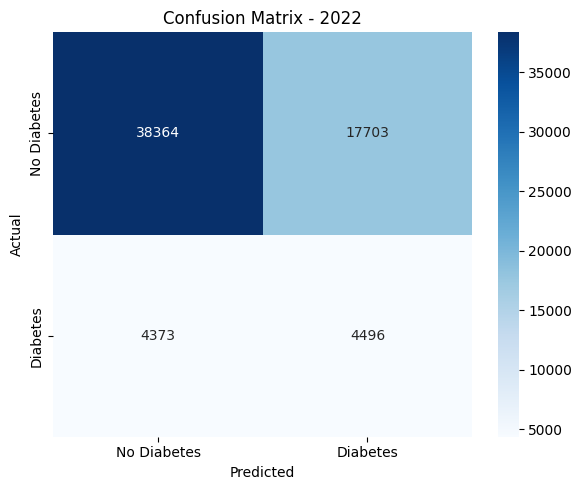

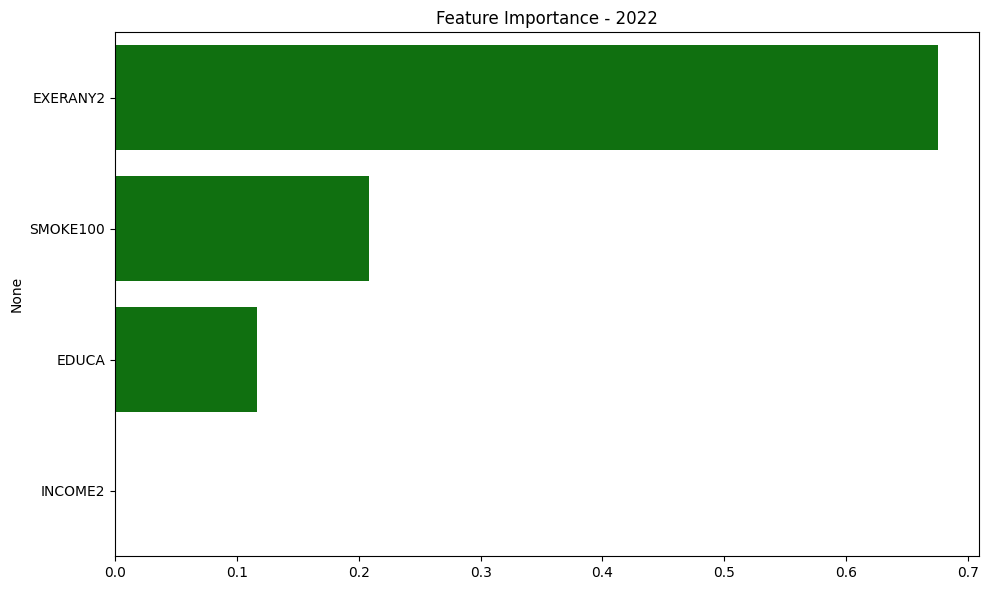


Processing Year: 2023
Using 4 features: ['SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']
Optimal Threshold (best F1): 0.8112

Classification Report for 2023
              precision    recall  f1-score   support

           0       0.90      0.62      0.73     52578
           1       0.19      0.55      0.28      8338

    accuracy                           0.61     60916
   macro avg       0.54      0.59      0.51     60916
weighted avg       0.80      0.61      0.67     60916

False Positives: 19885 (37.82%)
False Negatives: 3755 (45.03%)
Precision: 0.1873
Recall: 0.5497


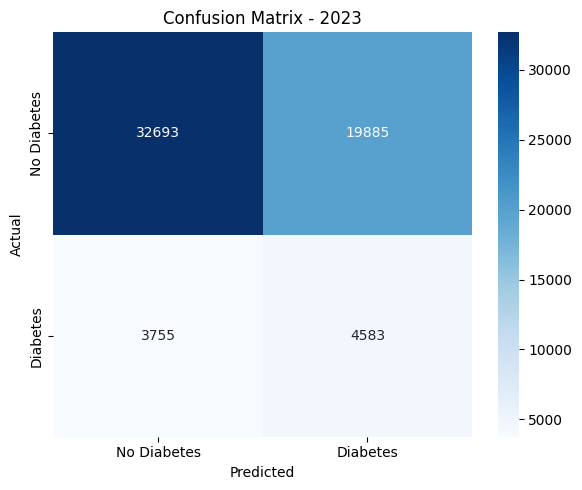

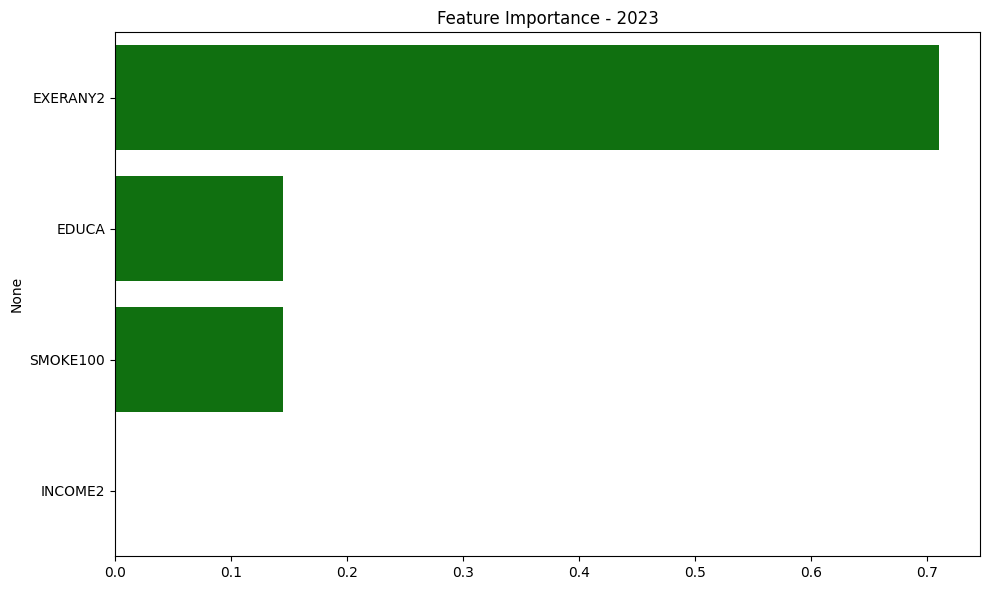

In [26]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# Load data
years = ['2019', '2020', '2021', '2022', '2023']
columns = ['DIABETE4', 'SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']

dfs = []
for year in years:
    filename = f"LLCP{year}.XPT"
    df = pd.read_sas(filename, format='xport')
    df['year'] = int(year)
    valid_cols = [col for col in columns if col in df.columns]
    df = df[valid_cols + ['year']]
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
df = combined_df.copy()

# Replace invalids with NaN
for col in ['DIABETE4', 'SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']:
    df[col] = df[col].replace([7, 9, 77, 88, 99, 777, 999], pd.NA)

# Create binary target
df['diabetes'] = df['DIABETE4'].replace({
    1: 1,
    2: 0,
    3: 0,
    4: 0
})
df = df.drop(columns=['DIABETE4'])

# Impute using mode
for col in ['SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2']:
    df[col] = df[col].fillna(df[col].mode()[0])

clean_df = df.copy()

# Modeling
base_features = [
    'SMOKE100', 'EXERANY2', 'EDUCA', 'INCOME2', 'GENHLTH',
    'DIFFWALK', 'HIGHBP', 'CHOLCHK', 'FRUIT2', 'VEGETAB2',
    'HLTHPLN1', 'DIFFDRES', 'MENTHLTH', 'PHYSHLTH', 'SEX', 'AGE'
]
target = 'diabetes'
yearly_results = {}

for year in sorted(clean_df['year'].unique()):
    print(f"\n{'='*50}\nProcessing Year: {year}\n{'='*50}")

    df_year = clean_df[clean_df['year'] == year].copy()
    if len(df_year) < 500:
        print(f"Skipping {year}: Not enough data.")
        continue

    features = [f for f in base_features if f in df_year.columns]

    # BMI features
    bmi_col = next((b for b in ['_BMI5', 'BMI5', 'BMI'] if b in df_year.columns), None)
    if bmi_col:
        df_year['BMI_CAT'] = pd.cut(df_year[bmi_col], bins=[0, 1850, 2500, 3000, 10000], labels=['Under', 'Normal', 'Over', 'Obese'])
        features.append('BMI_CAT')
        if 'AGE' in df_year.columns:
            df_year['AGE_BMI'] = df_year['AGE'] * df_year[bmi_col] / 10000
            features.append('AGE_BMI')

    # Health Index
    health_cols = [col for col in ['GENHLTH', 'PHYSHLTH', 'MENTHLTH'] if col in df_year.columns]
    if len(health_cols) >= 2:
        df_year['HEALTH_INDEX'] = df_year[health_cols].mean(axis=1)
        features.append('HEALTH_INDEX')

    features = [f for f in features if f in df_year.columns]
    if len(features) == 0:
        print(f"Skipping {year}: No usable features found.")
        continue

    print(f"Using {len(features)} features: {features}")

    df_year = df_year.dropna(subset=[target])
    if df_year.empty:
        print(f"Skipping {year}: No data with target.")
        continue

    imputer = SimpleImputer(strategy='most_frequent')
    df_year[features] = imputer.fit_transform(df_year[features])

    X = pd.get_dummies(df_year[features], drop_first=True)
    y = df_year[target].astype(int)

    if y.nunique() < 2:
        print(f"Skipping {year}: Only one class present.")
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    if len(X_train) > 5000:
        X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=5000, stratify=y_train, random_state=42)

    try:
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train)
    except Exception as e:
        print(f"SMOTE failed: {e}. Using original training set.")
        X_res, y_res = X_train, y_train

    model = XGBClassifier(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=5,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_res, y_res)
    y_proba = model.predict_proba(X_test)[:, 1]

    best_f1, best_thresh = 0, 0.5
    for t in np.linspace(0.1, 0.95, 50):
        y_tmp = (y_proba >= t).astype(int)
        score = f1_score(y_test, y_tmp, zero_division=0)
        if score > best_f1:
            best_f1 = score
            best_thresh = t

    optimal_threshold = best_thresh
    print(f"Optimal Threshold (best F1): {optimal_threshold:.4f}")
    y_pred = (y_proba >= optimal_threshold).astype(int)

    print(f"\nClassification Report for {year}")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        print(f"False Positives: {fp} ({fp / (fp + tn + 1e-6) * 100:.2f}%)")
        print(f"False Negatives: {fn} ({fn / (fn + tp + 1e-6) * 100:.2f}%)")
        print(f"Precision: {tp / (tp + fp + 1e-6):.4f}")
        print(f"Recall: {tp / (tp + fn + 1e-6):.4f}")

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(f"Confusion Matrix - {year}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Feature Importance Plot
    feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    yearly_results[year] = feat_imp

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index, color='green')
    plt.title(f"Feature Importance - {year}")
    plt.tight_layout()
    plt.show()
